In [3]:
!pip install pillow

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1241: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)


Goal reached.
Failed to save GIF: list index out of range


<ipython-input-7-dee87c5134da>:130: UserWarning: You passed in an explicit save_count=12686 which is being ignored in favor of frames=12686.
  ani = animation.FuncAnimation(


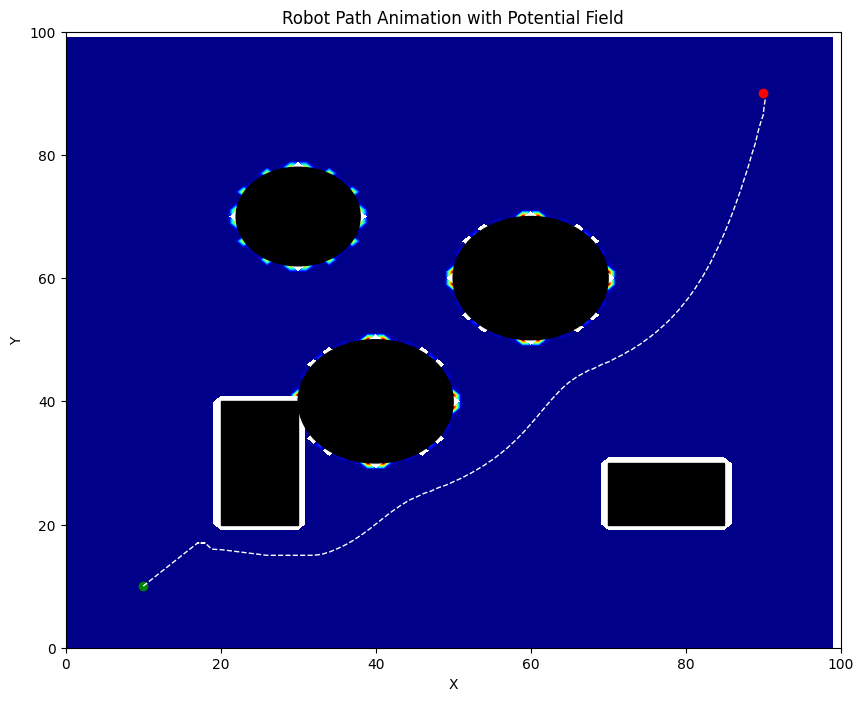

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import csv
from PIL import Image
from matplotlib.animation import PillowWriter

# Grid setup
X, Y = np.meshgrid(np.arange(0, 100), np.arange(0, 100))

# Start and Goal
start = np.array([10.0, 10.0])
goal = np.array([90.0, 90.0])

# Obstacles
obstacles = [
    ("circle", (40, 40, 10)),
    ("circle", (60, 60, 10)),
    ("circle", (30, 70, 8)),
    ("rectangle", (20, 20, 10, 20)),
    ("rectangle", (70, 20, 15, 10)),
]

# Potential functions
def attractive_potential(x, y, goal, k_att=1.0):
    return 0.5 * k_att * ((x - goal[0])**2 + (y - goal[1])**2)

def repulsive_potential(x, y, obstacles, k_rep=10000.0, Q_star=200.0):
    U_rep = np.zeros_like(x, dtype=float)
    for typ, obs in obstacles:
        if typ == "circle":
            ox, oy, r = obs
            d = np.sqrt((x - ox)**2 + (y - oy)**2) - r
        elif typ == "rectangle":
            rx, ry, w, h = obs
            dx = np.maximum(np.maximum(rx - x, 0), x - (rx + w))
            dy = np.maximum(np.maximum(ry - y, 0), y - (ry + h))
            d = np.sqrt(dx**2 + dy**2)
        else:
            continue
        mask = d <= Q_star
        with np.errstate(divide='ignore', invalid='ignore'):
            U_rep[mask] += 0.5 * k_rep * ((1.0 / d[mask] - 1.0 / Q_star)**2)
    return U_rep

# Total potential
U_att = attractive_potential(X, Y, goal)
U_rep = repulsive_potential(X, Y, obstacles)
U_total = U_att + U_rep

# Gradient of potential
gy, gx = np.gradient(-U_total)

# Path planning
alpha = 0.01
epsilon = 1e-4
max_steps = 500000

path = [start.copy()]
current = start.copy()

for _ in range(max_steps):
    if np.any(np.isnan(current)) or np.any(current < 0) or current[0] >= gx.shape[1] or current[1] >= gx.shape[0]:
        print("Path terminated due to invalid robot position.")
        break

    ix, iy = int(current[0]), int(current[1])
    dx, dy = gx[iy, ix], gy[iy, ix]
    grad = np.array([dx, dy])
    norm = np.linalg.norm(grad)

    if norm < epsilon:
        print("Gradient too small, robot stopped.")
        break

    step = alpha * grad / norm
    current = current + step
    path.append(current.copy())

    if np.linalg.norm(current - goal) < 1.0:
        print("Goal reached.")
        break

path = np.array(path)

# Save to CSV
with open("potential_field_path.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["x", "y"])
    writer.writerows(path)

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title("Robot Path Animation with Potential Field")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.contourf(X, Y, U_total, levels=50, cmap='jet')

# Obstacles
for typ, obs in obstacles:
    if typ == "circle":
        ox, oy, r = obs
        circle = plt.Circle((ox, oy), r, color='black', fill=True)
        ax.add_patch(circle)
    elif typ == "rectangle":
        rx, ry, w, h = obs
        rect = plt.Rectangle((rx, ry), w, h, color='black', fill=True)
        ax.add_patch(rect)

# Start, goal, and path
ax.plot(start[0], start[1], 'go', label='Start')
ax.plot(goal[0], goal[1], 'ro', label='Goal')
ax.plot(path[:, 0], path[:, 1], 'w--', linewidth=1, label='Planned Path')

# Animation setup
robot_dot, = ax.plot([], [], 'yo', markersize=10, label='Robot')

def init():
    robot_dot.set_data([], [])
    return robot_dot,

def update(frame):
    robot_dot.set_data(path[frame][0], path[frame][1])
    return robot_dot,

# Animate only if path has enough points
if len(path) > 2:
    ani = animation.FuncAnimation(
        fig,
        update,
        init_func=init,
        frames=len(path),
        interval=10,
        repeat=False,
        blit=False,             # 🔧 Turn off blit
        save_count=len(path)    # ✅ Ensure all frames are saved
    )

    # Save the animation as GIF
    try:
        ani.save("potential_field_animation.gif", writer=PillowWriter(fps=20))
        print("GIF saved as 'potential_field_animation.gif'")
    except Exception as e:
        print(f"Failed to save GIF: {e}")
else:
    print("Not enough path points to animate.")
